# Задача

Представим, что мы построили социальную сеть для студентов Karpov Courses, которая обладает следующим функционалом: можно отправлять друг другу письма, создавать сообщества, аналогичные группам в известных сетях, и в этих сообществах публиковать посты.

Из приятного – при регистрации студенты должны заполнять данные по своему профилю, которые хранятся в поднятой на наших мощностях postgres database.

Так же наша платформа обладает лентой, которую пользователи могут листать и просматривать случайные записи случайных сообществ. Если пост нравится, можно поддержать автора и поставить like.

Все действия пользователей сохраняются, каждая их активность, связанная с просмотром постов, тоже записывается к нам в базу.

Платформа Karpov Courses заинтересована в благосостоянии студентов, поэтому разработчики решили усовершенствовать текущую ленту. А что, если показывать пользователям не случайные посты, а рекомендовать их точечно каждому пользователю из всего имеющегося множества написанных постов? Как это сделать и учесть индивидуальные характеристики профиля пользователя, его прошлую активность и содержимое самих постов?

В текущем проекте необходимо реализовать сервис, который будет для каждого юзера в любой момент времени возвращать посты, которые пользователю покажут в его ленте соцсети.

# Библиотеки

Импортируем всё, что понадобится в дальнейшем решении

In [1]:
import pandas as pd
import numpy as np

import random

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

from sklearn.feature_extraction.text import TfidfVectorizer

from catboost import CatBoostClassifier

# Описание данных

## Таблица user_data
Cодержит информацию о всех пользователях соц.сети


Название колонки | Описание
---------------- | ------
age              |	Возраст пользователя (в профиле)
city             |	Город пользователя (в профиле)
country          |	Страна пользователя (в профиле)
exp_group        |	Экспериментальная группа: некоторая зашифрованная категория
gender           |	Пол пользователя
id               |	Уникальный идентификатор пользователя
os               |	Операционная система устройства, с которого происходит пользование соц.сетью
source           |	Пришел ли пользователь в приложение с органического трафика или с рекламы

In [2]:
users = pd.read_sql(
    """
SELECT * FROM public.user_data
    """,
    con="*****"
)

users.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [3]:
users.shape

(163205, 8)

## Таблица post_text_df

Содержит информацию о постах и уникальный ID каждой единицы с соответствующим ей текстом и темой

Название колонки | Описание
---------------- | ------
id               |Уникальный идентификатор поста
text             |Текстовое содержание поста
topic            |Основная тематика

In [4]:
posts = pd.read_sql(
    """
SELECT * FROM public.post_text_df
    """,
    con="*****"
)

posts.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [5]:
posts.shape

(7023, 3)

## Таблица feed_data
Содержит историю о просмотренных постах для каждого юзера в изучаемый период.

Название колонки | Описание
---------------- | ------
timestamp	     | Время, когда был произведен просмотр
user_id	         | id пользователя, который совершил просмотр
post_id	         | id просмотренного поста
action	         | Тип действия: просмотр или лайк
target	         | 1 у просмотров, если почти сразу после просмотра был совершен лайк, иначе 0. У действий like пропущенное значение.

Таблица feed_data большая (~ 60 млн. строк), поэтому случайно выберем несколько тысяч пользователей и выгрузим данные для них. Oставим только записи с `action = 'view'`, так как сведения о лайках будут отражены в `target`

In [6]:
random.seed(123)

users_2k = tuple(random.sample(list(users['user_id'].values), 2000))

In [7]:
feed_2k = pd.read_sql(
    """
SELECT * FROM public.feed_data
WHERE action = 'view' AND user_id IN {}
    """.format(users_2k),
    con="*****"
)

feed_2k.head()

,timestamp,user_id,post_id,action,target
0,2021-10-18 20:10:11,26576,1834,view,0
1,2021-10-01 06:36:05,26576,1105,view,0
2,2021-10-01 06:38:01,26576,2975,view,0
3,2021-10-01 06:39:10,26576,6327,view,0
4,2021-10-01 06:40:25,26576,6153,view,1


In [8]:
feed_2k.shape

(845189, 5)

Объединим данные трёх таблиц

In [9]:
tmp = pd.merge(feed_2k, 
               users, 
               on='user_id', 
               how='left')

feed_full = pd.merge(tmp,
                    posts,
                    on='post_id',
                    how='left')

feed_full = feed_full.drop('action', axis=1) # по логике запроса везде будет значение 'view', эта колонка смысла не несёт

feed_full.head()

,timestamp,user_id,post_id,target,gender,age,country,city,exp_group,os,source,text,topic
0,2021-10-18 20:10:11,26576,1834,0,0,17,Russia,Cherepanovo,4,Android,ads,Hamm bows out for US\n\nWomens football legend...,sport
1,2021-10-01 06:36:05,26576,1105,0,0,17,Russia,Cherepanovo,4,Android,ads,Observers to monitor UK election\n\nMinisters ...,politics
2,2021-10-01 06:38:01,26576,2975,0,0,17,Russia,Cherepanovo,4,Android,ads,It was reported that a witness said he heard t...,covid
3,2021-10-01 06:39:10,26576,6327,0,0,17,Russia,Cherepanovo,4,Android,ads,I think Ive seen all of the Grisham movies now...,movie
4,2021-10-01 06:40:25,26576,6153,1,0,17,Russia,Cherepanovo,4,Android,ads,I really dont know why I agreed to watch this ...,movie


Проверим, приведена ли колонка `timestamp` к типу `datetime`. И посмотрим, есть ли пропуски в данных.

In [10]:
feed_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 845189 entries, 0 to 845188
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  845189 non-null  datetime64[ns]
 1   user_id    845189 non-null  int64         
 2   post_id    845189 non-null  int64         
 3   target     845189 non-null  int64         
 4   gender     845189 non-null  int64         
 5   age        845189 non-null  int64         
 6   country    845189 non-null  object        
 7   city       845189 non-null  object        
 8   exp_group  845189 non-null  int64         
 9   os         845189 non-null  object        
 10  source     845189 non-null  object        
 11  text       845189 non-null  object        
 12  topic      845189 non-null  object        
dtypes: datetime64[ns](1), int64(6), object(6)
memory usage: 90.3+ MB


Как видим, везде всё в порядке.

# Метрика

## Hitrate @5

$$ \frac{1}{n} \sum_{i = 1}^n min (1, \sum_{j=1}^5 [a_j(x_i) = 1]), $$

где n - количество юзеров

$a_j(x_i)$ - j-ая рекомендация i-ому пользователю

# Разведочный анализ данных (EDA)

## Числовые признаки 

(Признаки пол и экспериментальная группа в дальнейшем будем считать категориальными, но для построения графиков можно оставить числовыми)

Для начала посмотрим на общую информацию.

In [11]:
feed_full.describe()

,user_id,post_id,target,gender,age,exp_group
count,845189.000000,845189.000000,845189.000000,845189.000000,845189.000000,845189.000000
mean,83650.393937,3390.494902,0.118532,0.548176,27.055216,2.019230
std,48481.969957,2092.955238,0.323237,0.497674,9.976749,1.401736
min,230.000000,1.000000,0.000000,0.000000,14.000000,0.000000
25%,39087.000000,1525.000000,0.000000,0.000000,20.000000,1.000000
50%,85206.000000,3177.000000,0.000000,1.000000,24.000000,2.000000
75%,125066.000000,5198.000000,0.000000,1.000000,33.000000,3.000000
max,168454.000000,7319.000000,1.000000,1.000000,71.000000,4.000000


Из представленной таблицы виден заметный перекос в сторону 0 класса и небольшое преобладание пола, обозначенного единицей. Кроме того, отметим, что минимальный возраст пользователей нашей соц сети - 14 лет, максимальный - 71, среднее значение - 27 лет.

Далее посмотрим, как между собой коррелируют числовые признаки.

In [12]:
corrs = feed_full.drop(['user_id', 'post_id'], axis=1).corr()
corrs

,target,gender,age,exp_group
target,1.000000,0.029741,0.002053,-0.007477
gender,0.029741,1.000000,-0.003242,0.039145
age,0.002053,-0.003242,1.000000,-0.027414
exp_group,-0.007477,0.039145,-0.027414,1.000000


<AxesSubplot:>

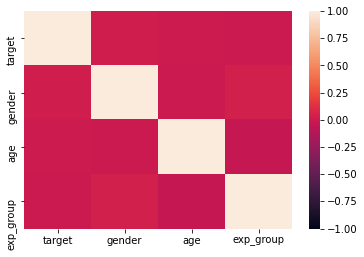

In [13]:
sns.heatmap(corrs,
            vmin=-1,
            vmax=1)

Явной корреляции между признаками не наблюдается.

Теперь посмотрим на распределение данных по возрасту, полу, экспериментальной группе и целевой переменной.

array([[<AxesSubplot:title={'center':'target'}>,
        <AxesSubplot:title={'center':'gender'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'exp_group'}>]], dtype=object)

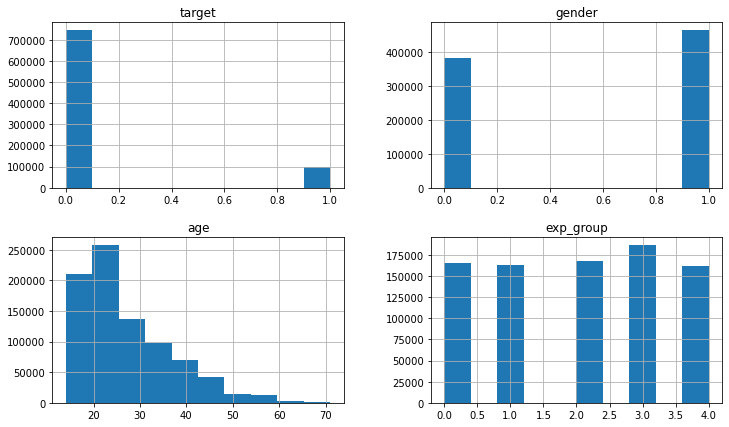

In [14]:
feed_full.drop(['timestamp', 'user_id', 'post_id'], axis=1).hist(figsize=(12, 7))

На полученных гистограммах виден значительный дисбаланс классов. Также в наших данных больше людей пола, обозначенного единицей. Распределение по экспериментальным группам довольно равномерное. А из гистограммы значений возраста видно, что преобладающей группой являются пользователи от 14 до 25 лет.

Отдельно посмотрим на распределение данных по времени.

<AxesSubplot:>

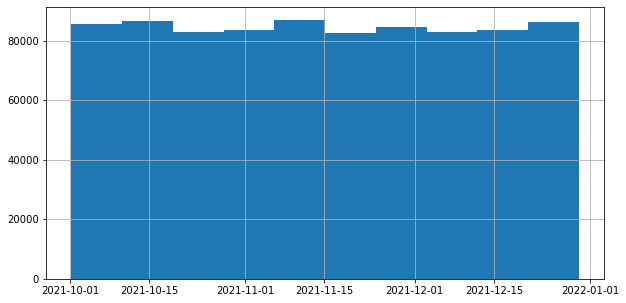

In [15]:
feed_full['timestamp'].hist(figsize=(10, 5))

Видно, что по времени данные распределены достаточно равномерно. Рассматриваемый период времени - 3 месяца.

Далее посмотрим, как распределена таргетная переменная по возрастам пользователей.

<AxesSubplot:xlabel='age', ylabel='target'>

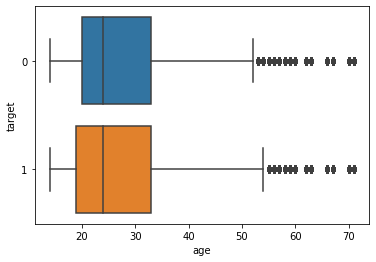

In [16]:
sns.boxplot(y=feed_full['target'].astype('category'), x='age', data=feed_full)

По данному графику заметно, что распределения класса 0 и класса 1 по возрастам похожи. Медиана обоих распределений приходится на 24 года, интерквантильный размах практически не отличается. Большиснтво значений лежит в промежутке от 14 до ~50 лет, а значения для пользователей старше 50 отмечены как потенциальные выбросы.

## Категориальные признаки

Начнем с общей информации.

In [17]:
feed_full.describe(include='object')

,country,city,os,source,text,topic
count,845189,845189,845189,845189,845189,845189
unique,10,644,2,2,6747,7
top,Russia,Moscow,Android,ads,Debate needed on donations cap\n\nA cap on don...,movie
freq,756013,124060,535784,538646,593,311501


Из данной таблицы видно, что в нашу выборку попали не все посты. Можно постараться сделать выборку более стратифицированной (не только по постам, но и по пользователям) или найти компьютер с большим количеством оперативной памяти :(

Еще видно, что у всех категорий, кроме города, не очень много уникальных значений, поэтому посмотрим на распределение данных по ним.

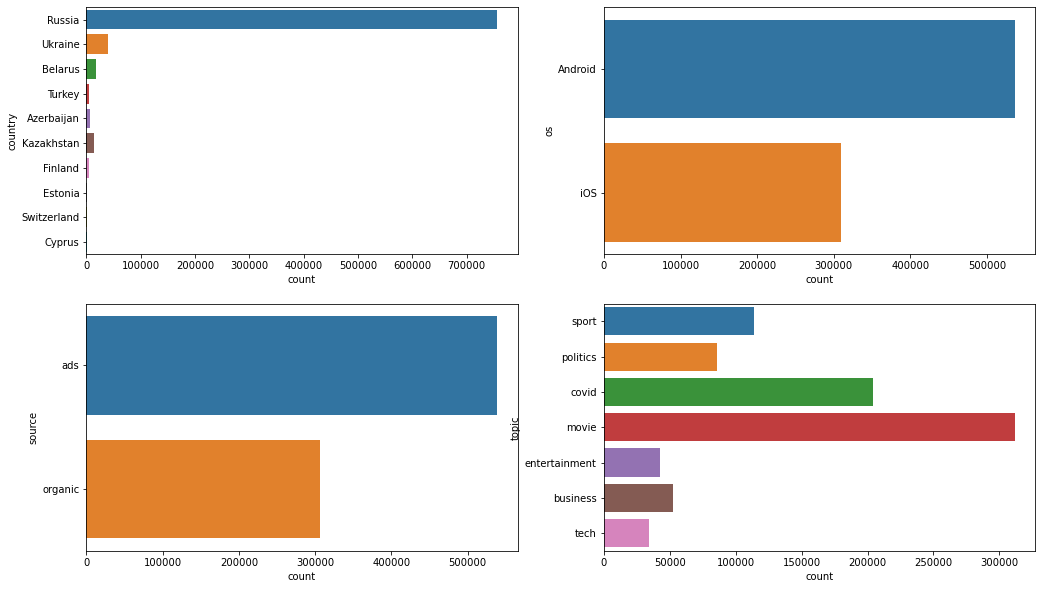

In [18]:
cat_cols = [['country', 'os'], 
            ['source', 'topic']]

fig, axes = plt.subplots(2, 2, figsize=(17, 10))

for i in range(2):
    for j in range(2):
        sns.countplot(y=cat_cols[i][j], data=feed_full, ax=axes[i][j])

Из полученных графиков видно, что подавляющее большинство пользователей из России. Следующие по количеству пользователей три страны: Украина, Беларусь и Казахстан. Кроме того, практически в два раза больше позователей пользуются нашей соц. сетью с Android'а и приходят в приложение с рекламы.

Также можно сделать вывод о постах. Наибольшее количество постов о кино и коронавирусе. Чуть меньше о спорте и политике. Затем по численности идут бизнес, развлечения и технологии.

Теперь посмотрим на распределение таргетной переменной по этим категориям. Построим диаграммы в процентном соотношении, чтобы не учитывать сильный дисбаланс классов.

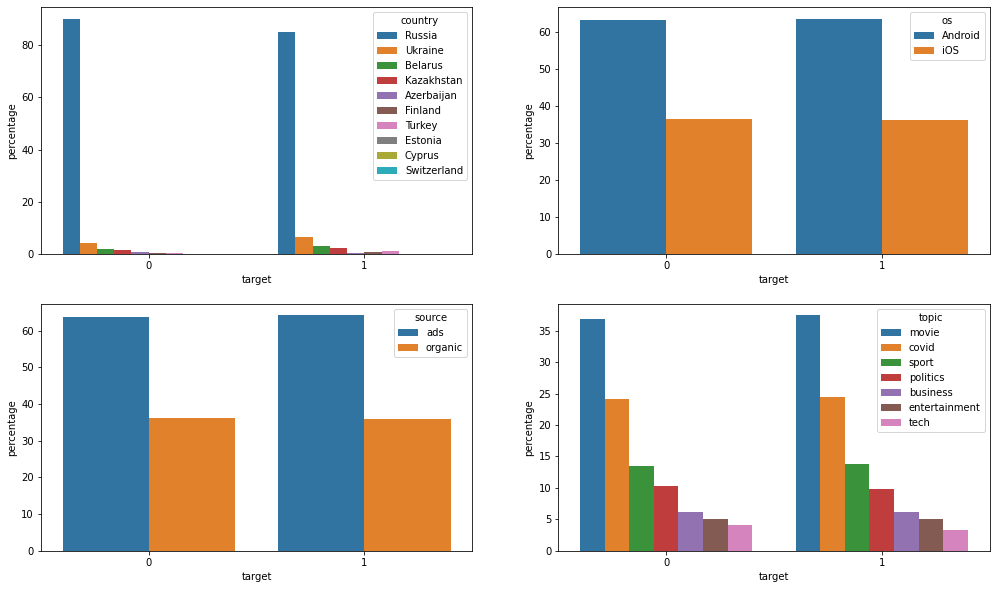

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(17, 10))

for i in range(2):
    for j in range(2):
        df_col = feed_full.groupby('target')[cat_cols[i][j]].value_counts(normalize=True)
        df_col = df_col.mul(100)
        df_col = df_col.rename('percentage').reset_index()

        sns.barplot(x='target', y='percentage', hue=cat_cols[i][j], data=df_col, ax=axes[i][j])

Видно, что в процентном соотношении 0 и 1 класс одинаково распределены по категориям.

# Разделение на тренировочную и тестовую выборки

Оставим для обучения и теста только тех пользовтелей, у которых лайки составляют хотя бы 10 процентов от просмотров.

In [20]:
likes_views = feed_full.groupby('user_id').agg(likes=('target', np.sum),
                                               views=('target', len)).reset_index()

valid_users = likes_views[likes_views['likes'] >= 0.1 * likes_views['views']]['user_id'].values

valid_feed = feed_full[feed_full['user_id'].isin(valid_users)]

Отправим 80 процентов пользователей в тренировчную часть, остальных в тестовую

In [21]:
random.seed(123)

train_users = random.sample(list(valid_users), int(0.8 * len(valid_users)))
test_users = np.setdiff1d(valid_users, train_users)

In [22]:
train_feed = valid_feed[valid_feed['user_id'].isin(train_users)]
test_feed = valid_feed[valid_feed['user_id'].isin(test_users)]

train_feed.shape, test_feed.shape

((412152, 13), (100717, 13))

# Baseline

## Глобальные рекомендации
Для начала попробуем рекомендовать всем пользователям топ-5 всех постов. 

Однако так как у нас нет данных о взаимодействии всех пользователей со всеми постами, измерять hitrate на глобальных рекомендациях будет проблематично. Возможно тестовому пользователю и понравился пост из глобального топ-5, но мы просто об этом не знаем. Поэтому поступим немного хитрее и каждому пользователю будем рекомендовать топ-5 постов из тех, по которым у нас есть данные. Стоит понимать, что это не совсем честный подход и значение метрики наверняка получится завышенным.

Для этого вытащим из таблицы `feed_data`, сколько раз каждый пост лайкали пользователи. Возьмём данные по всем постам для реализации описанной выше идеи и на случай, если захотим давать больше, чем 5 рекомендаций.

In [23]:
feed_likes = pd.read_sql(
    """
SELECT post_id, COUNT(user_id) AS likes_num
FROM public.feed_data
WHERE action = 'like'
GROUP BY post_id
ORDER BY likes_num DESC
    """,
    con="*****"
)


feed_likes.head()

,post_id,likes_num
0,1141,2968
1,1634,2963
2,1707,2952
3,1883,2929
4,1685,2927


Посчитаем hitrate@5 для пользователей из тестовой выборки

In [24]:
def global_hitrate(test_users, test_feed, limit=5):
    hits = 0
    for user in test_users:
        counter = 0
        one_feed = test_feed[test_feed['user_id'] == user]

        one_posts = one_feed['post_id'].values
        one_likes = one_feed[one_feed['target'] == 1]['post_id'].values

        for post in feed_likes['post_id'].values:
            if post in one_posts:
                counter += 1
                if post in one_likes:
                    hits += 1
                    break
            if counter == limit:
                break
                
    return round(hits / len(test_users), 3)
            
print(f'hitrate @5 global (train) = {global_hitrate(train_users, train_feed)}')
print(f'hitrate @5 global (test) = {global_hitrate(test_users, test_feed)}')

hitrate @5 global (train) = 0.619
hitrate @5 global (test) = 0.607


# Работа с датой и временем

Предпочтения пользователей могут отличаться в разные периоды времени, поэтому будем использовать это как признаки. Так как в нашей выборке данные только за один год, в качестве признаков возьмём значения месяца, дня и часа. Минуты и секунды кажутся слишком маленькими периодами времени, чтобы что-то могло измениться, поэтому их использовать в обучении не будем.

In [25]:
feed_full['month'] = feed_full['timestamp'].dt.month
feed_full['day'] = feed_full['timestamp'].dt.day
feed_full['hour'] = feed_full['timestamp'].dt.hour

feed_full = feed_full.drop('timestamp', axis=1)

feed_full.head()

,user_id,post_id,target,gender,age,country,city,exp_group,os,source,text,topic,month,day,hour
0,26576,1834,0,0,17,Russia,Cherepanovo,4,Android,ads,Hamm bows out for US\n\nWomens football legend...,sport,10,18,20
1,26576,1105,0,0,17,Russia,Cherepanovo,4,Android,ads,Observers to monitor UK election\n\nMinisters ...,politics,10,1,6
2,26576,2975,0,0,17,Russia,Cherepanovo,4,Android,ads,It was reported that a witness said he heard t...,covid,10,1,6
3,26576,6327,0,0,17,Russia,Cherepanovo,4,Android,ads,I think Ive seen all of the Grisham movies now...,movie,10,1,6
4,26576,6153,1,0,17,Russia,Cherepanovo,4,Android,ads,I really dont know why I agreed to watch this ...,movie,10,1,6


# Обработка текста

Посчитаем средний TF-IDF для всех постов

In [26]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(posts['text'])

tfs = tfidf.transform(posts['text'])

posts['mean'] = np.mean(tfs, axis=1)

posts.head()

,post_id,text,topic,mean
0,1,UK economy facing major risks\n\nThe UK manufa...,business,0.000179
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,0.000239
2,3,Asian quake hits European shares\n\nShares in ...,business,0.000256
3,4,India power shares jump on debut\n\nShares in ...,business,0.000137
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,0.000131


In [27]:
feed_full = pd.merge(feed_full,
                     posts[['post_id', 'mean']],
                     on='post_id',
                     how='left')

feed_full.head()

,user_id,post_id,target,gender,age,country,city,exp_group,os,source,text,topic,month,day,hour,mean
0,26576,1834,0,0,17,Russia,Cherepanovo,4,Android,ads,Hamm bows out for US\n\nWomens football legend...,sport,10,18,20,0.000132
1,26576,1105,0,0,17,Russia,Cherepanovo,4,Android,ads,Observers to monitor UK election\n\nMinisters ...,politics,10,1,6,0.000214
2,26576,2975,0,0,17,Russia,Cherepanovo,4,Android,ads,It was reported that a witness said he heard t...,covid,10,1,6,0.000066
3,26576,6327,0,0,17,Russia,Cherepanovo,4,Android,ads,I think Ive seen all of the Grisham movies now...,movie,10,1,6,0.000148
4,26576,6153,1,0,17,Russia,Cherepanovo,4,Android,ads,I really dont know why I agreed to watch this ...,movie,10,1,6,0.000159


# Catboost

Обучим на тренировочных данных `CatBoostClassifier`

Для начала обновим наш `valid_feed`, и соответственно `train_feed` и `test_feed`. На всякий случай проверим размерности

In [28]:
valid_feed = feed_full[feed_full['user_id'].isin(valid_users)]

train_feed = valid_feed[valid_feed['user_id'].isin(train_users)]
test_feed = valid_feed[valid_feed['user_id'].isin(test_users)]

train_feed.shape, test_feed.shape

((412152, 16), (100717, 16))

Уберём из тренировочной и тестовой выборки признаки, которые не будут использованы в обучении: `user_id`, `post_id` и `text` и отделим таргеты от выборок. 

In [29]:
X_train, y_train = train_feed.drop(['user_id', 'post_id', 'text', 'target'], axis=1), train_feed['target']
X_test, y_test = test_feed.drop(['user_id', 'post_id', 'text', 'target'], axis=1), test_feed['target']

Зададим категориальные колонки

In [30]:
cat_cols = ['gender', 'country', 'city', 'exp_group', 'os', 'source', 'topic']

Обучим `CatBoostClassifier`. Кроме дефолтного LogLoss, посмотрим еще на AUC, так как AUC более устойчива к несбалансированным данным. Также для учета дисбаланса классов выставим значение `auto_class_weights = 'Balanced`

In [31]:
cb = CatBoostClassifier(custom_loss='AUC',
                        auto_class_weights='Balanced',
                        random_seed=123)

cb.fit(X_train, y_train,
       cat_features=cat_cols,
       eval_set=(X_test, y_test),
       verbose=False,
       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Я не нашла, как заставить Catboost показывать графики при сохранении ноутбука, поэтому загружу хотя бы так :(

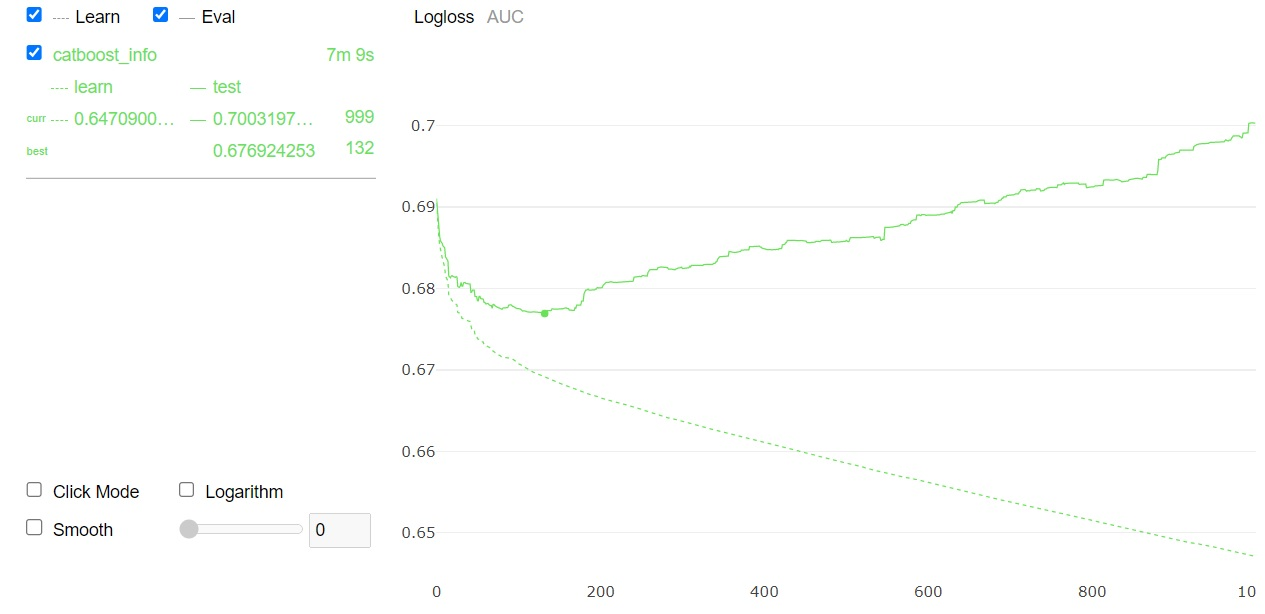

In [32]:
Image("LogLoss1.jpg")

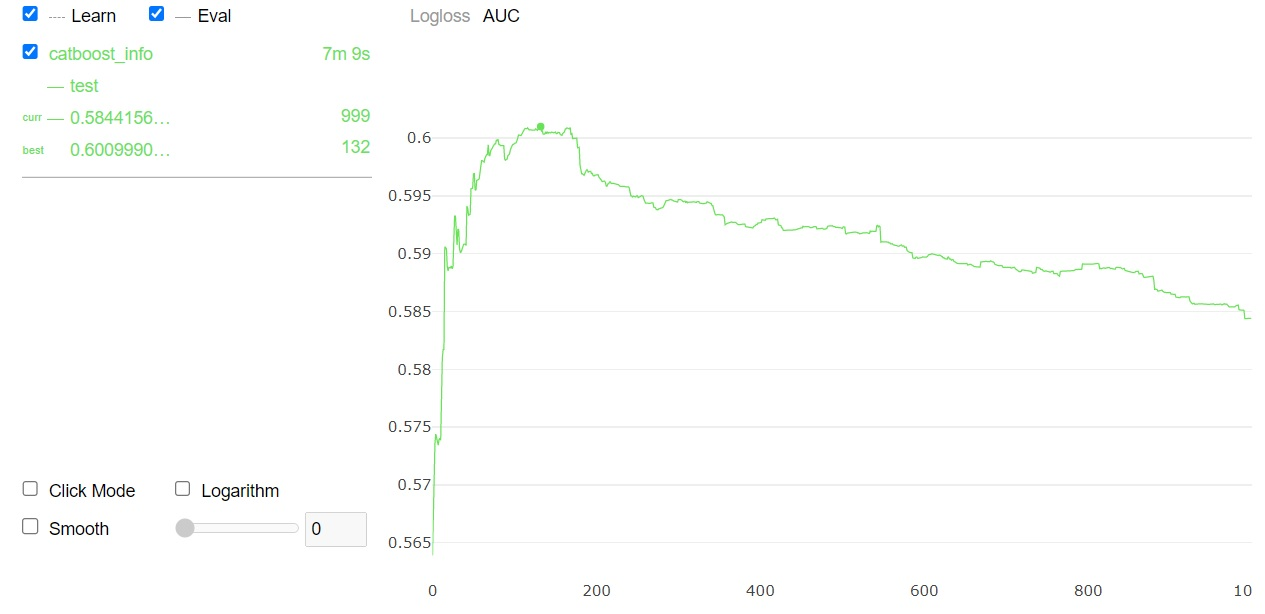

In [33]:
Image("AUC1.jpg")

Видно, что модель почти сразу начала переобучаться, лучшее значение метрик было достигнуто на 132 итерации, поэтому при дальнейшей настройке модели ограничимся 200 итераций.

Также посмотрим, как сильно отличается предсказанное соотношение классов от того, что было в тесте.

In [34]:
X_c = X_test.copy()

X_c['preds'] = cb.predict(X_test)

X_c['preds'].value_counts()

0    58194
1    42523
Name: preds, dtype: int64

In [35]:
y_test.value_counts()

0    85392
1    15325
Name: target, dtype: int64

Получили соотношение предсказанных классов примерно 50/50, поэтому попробуем использовать `auto_class_weights = 'SqrtBalanced'`

In [36]:
cb = CatBoostClassifier(iterations=200,
                        custom_loss='AUC',
                        auto_class_weights='SqrtBalanced',
                        random_seed=123)

cb.fit(X_train, y_train,
       cat_features=cat_cols,
       eval_set=(X_test, y_test),
       verbose=False,
       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

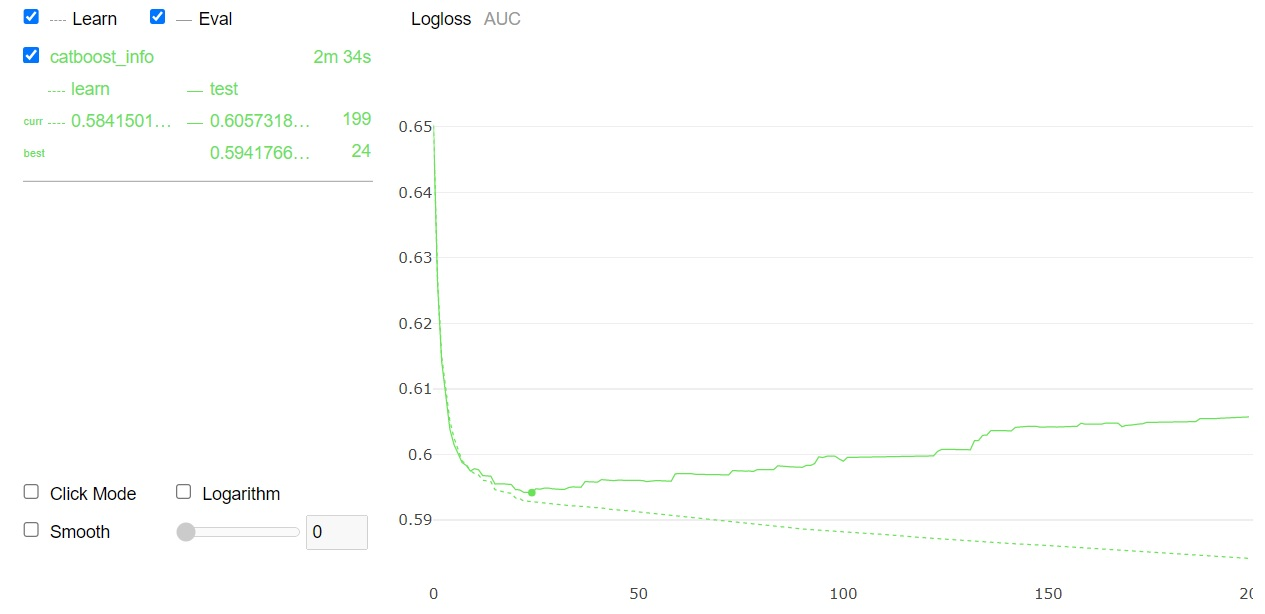

In [37]:
Image("LogLoss2.jpg")

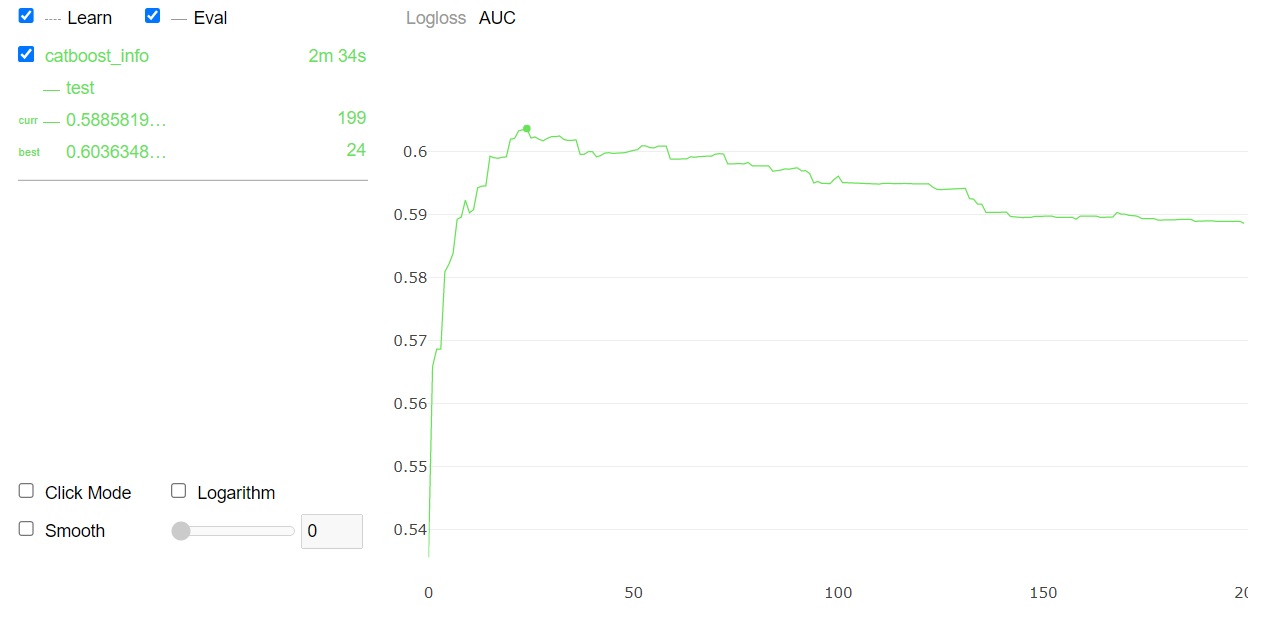

In [38]:
Image("AUC2.jpg")

Получили меньшее лучшее значение и LogLoss, и AUC.

Посмотрим на соотношение классов

In [39]:
X_c['preds'] = cb.predict(X_test)

X_c['preds'].value_counts()

0    100525
1       192
Name: preds, dtype: int64

Видим, что улучшение было достигнуто за счёт значительно меньшего детектирования интресующего нас класса 1. 

Попробуем самостоятельно подобрать веса классов.

In [40]:
weight_0 = round((y_train[y_train == 1].shape[0] / y_train.shape[0]) ** 0.85, 2)
weight_1 = round(1 - weight_0, 2)

weight_0, weight_1

(0.2, 0.8)

In [41]:
cb = CatBoostClassifier(iterations=200,
                        custom_loss='AUC',
                        class_weights=[weight_0, weight_1],
                        random_seed=123)

cb.fit(X_train, y_train,
       cat_features=cat_cols,
       eval_set=(X_test, y_test),
       verbose=False,
       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

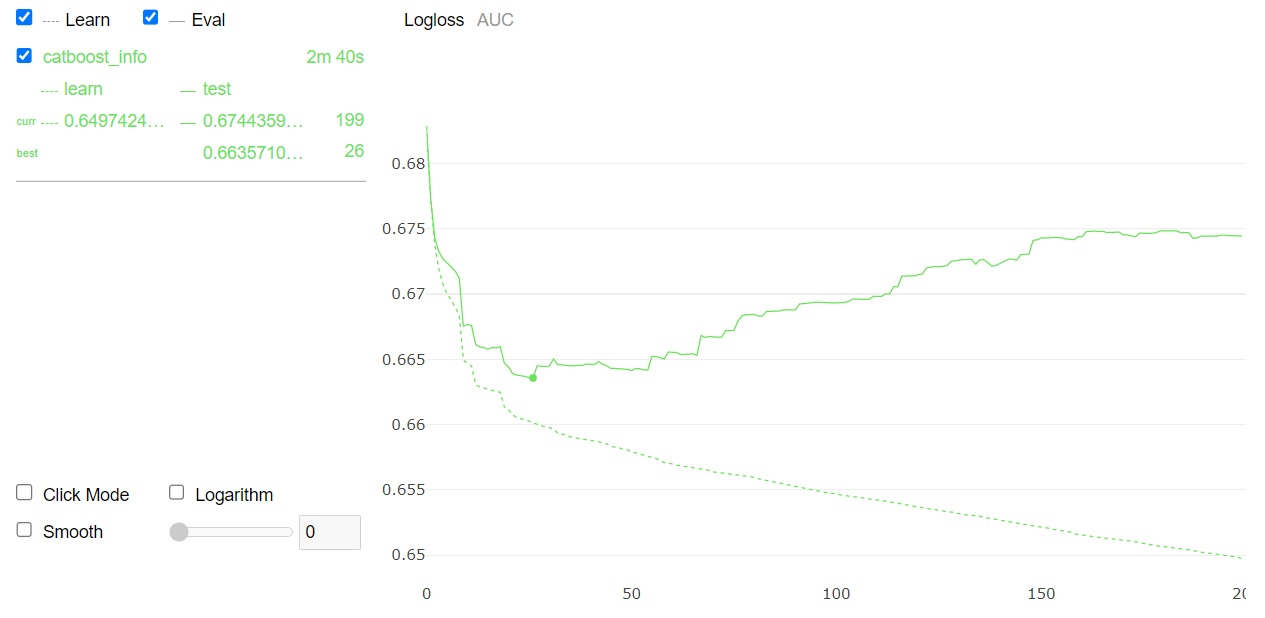

In [42]:
Image("LogLoss3.jpg")

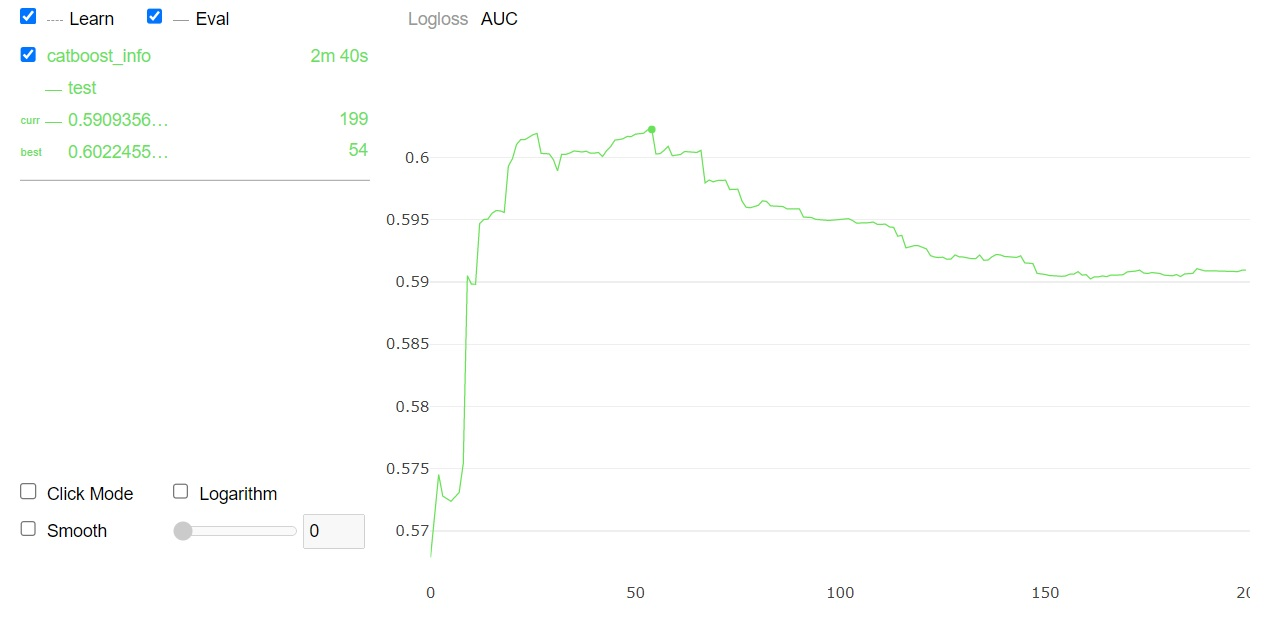

In [43]:
Image("AUC3.jpg")

In [44]:
X_c['preds'] = cb.predict(X_test)

X_c['preds'].value_counts()

0    83932
1    16785
Name: preds, dtype: int64

In [45]:
y_test.value_counts()

0    85392
1    15325
Name: target, dtype: int64

Ожидаемо увеличилось лучшее значение LogLoss, и немного уменьшилось лучшее значение AUC. Однако подбором весов удалось достичь похожего соотношения классов, поэтому выберем эту модель в качестве финальной.

Посчитаем hitrate@5 полученной модели

In [46]:
def hitrate_catboost(cb, test_users, X_test, test_feed, limit=5):
    feed_c = test_feed.copy()
    feed_c['preds'] = cb.predict(X_test)
    feed_c['preds_proba'] = cb.predict_proba(X_test)[:, 1]
    
    hits = 0
    for user in test_users:
        one_recs = feed_c[feed_c['user_id'] == user].sort_values(by='preds_proba',
                                                                 ascending=False).head(limit)
        
        if (one_recs['target'] == 1).any():
            hits += 1
            
    return round(hits / len(test_users), 3)

print(f'hitrate@5 Catboost (train) = {hitrate_catboost(cb, train_users, X_train, train_feed)}')
print(f'hitrate@5 Catboost (test) = {hitrate_catboost(cb, test_users, X_test, test_feed)}')

hitrate@5 Catboost (train) = 0.807
hitrate@5 Catboost (test) = 0.707


Видим, что модель переобучилась и нужно более аккуратно подобрать параметры (~~но дедлайны поджимают~~), однако даже так мы смогли добиться лучшего значения hitrate@5, чем с помощью глобальных рекомендаций.

Сохраним полученную модель.

In [47]:
cb.save_model('catboost_model', format="cbm")

Для того, чтобы проверить, является ли полученное улучшение статистически значимым, проведём A/B эксперимент (см. следующий ноутбук)